In [1]:
#@title 🔧 Setup: librerie
!pip -q install git+https://github.com/openai/CLIP.git ftfy regex tqdm scikit-learn matplotlib torchvision

import os, math, random, time, numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision.datasets import OxfordIIITPet
import clip
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import pairwise_distances
import torchvision.transforms.functional as TF



SEED = 7
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

model, preprocess = clip.load("ViT-B/32", device=device) # ViT-L/14, ViT-bigG
model.eval();


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.3 MB/s eta 0:00:00
Device: cpu


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 60.2MiB/s]


In [2]:
#@title 🐶 Donwload dataset

# ----------------------------
# Simple dataset cell (didactic)
# ----------------------------
import random
import torch
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import OxfordIIITPet

# Config
root = "./data"
BATCH = 64
MAX_SAMPLES = 1600   # set None to use the full split
VERBOSE = True       # toggle debug prints

# Download
ds_test = OxfordIIITPet(
    root=root,
    split="test",
    target_types="category",
    download=True,
    transform=preprocess,
)

# ds_test = torchvision.datasets.STL10(
#             root=root,
#             split="test",          # 'train' o 'test'
#             download=True,
#             transform=preprocess,
#         )

classes = ds_test.classes  # 37 classes (cats + dogs)
if VERBOSE:
    print(f"[Info] Loaded Oxford-IIIT Pet | classes={len(classes)} | total test samples={len(ds_test)}")

# Optional subsampling (for speed in demos)
idx = list(range(len(ds_test)))
if MAX_SAMPLES is not None and MAX_SAMPLES < len(idx):
    random.seed(0)  # make subsampling reproducible
    idx = random.sample(idx, MAX_SAMPLES)
    if VERBOSE:
        print(f"[Info] Subsampling: {len(ds_test)} -> {len(idx)} samples")

ds_sub = Subset(ds_test, idx)

# DataLoader
loader = DataLoader(
    ds_sub,
    batch_size=BATCH,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

if VERBOSE:
    print(f"[Info] DataLoader ready | batch_size={BATCH} | subset size={len(ds_sub)}")
    # Peek one batch to show shapes
    try:
        x, y = next(iter(loader))  # x: [B, C, H, W], y: [B]
        print(f"[Debug] First batch: images shape={tuple(x.shape)}, dtype={x.dtype}, device={x.device}")
        if torch.is_tensor(y):
            print(f"[Debug] Targets: shape={tuple(y.shape)}, dtype={y.dtype}, device={y.device}")
    except StopIteration:
        print("[Warning] Empty DataLoader (no samples in subset)")


100%|██████████| 792M/792M [00:26<00:00, 29.5MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 16.0MB/s]


[Info] Loaded Oxford-IIIT Pet | classes=37 | total test samples=3669
[Info] Subsampling: 3669 -> 1600 samples
[Info] DataLoader ready | batch_size=64 | subset size=1600


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[Debug] First batch: images shape=(64, 3, 224, 224), dtype=torch.float32, device=cpu
[Debug] Targets: shape=(64,), dtype=torch.int64, device=cpu


In [3]:
classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 1.000]


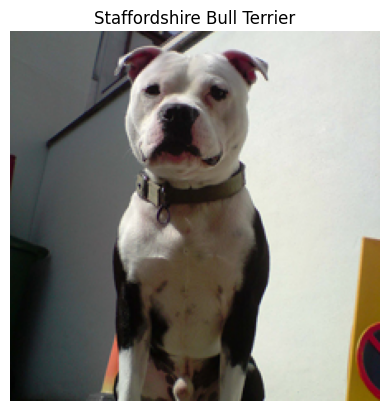

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.055, 0.922]


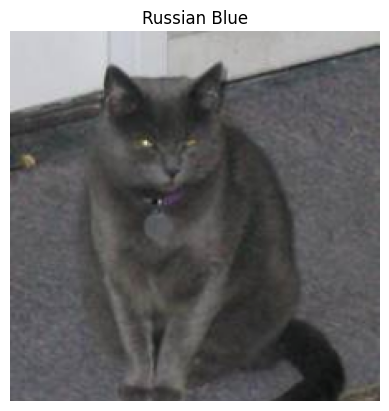

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 0.961]


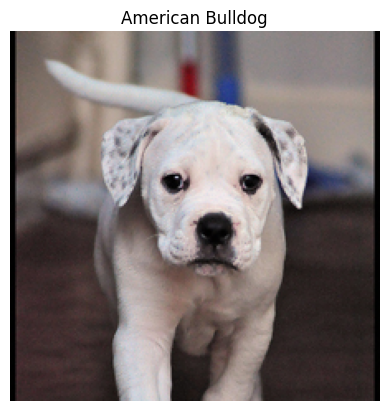

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 1.000]


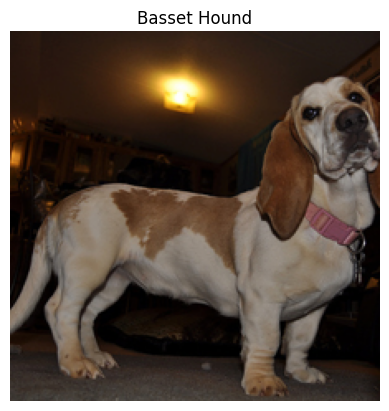

[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.047, 0.984]


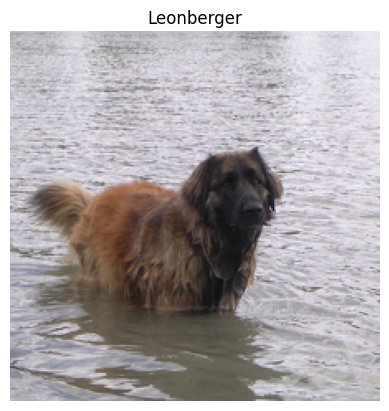

In [4]:


def display_image_from_tensor(image_tensor: torch.Tensor, title=None, verbose: bool = VERBOSE):
    """
    Denormalize and display a single image tensor.

    Args:
        image_tensor: Tensor [C, H, W], normalized with CLIP mean/std.
        title: Optional title (e.g., class label).
        verbose: Print small debug info.
    """
    assert image_tensor.ndim == 3, f"Expected [C,H,W], got {tuple(image_tensor.shape)}"

    # CLIP normalization stats (OpenAI CLIP)
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=image_tensor.device)
    std  = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=image_tensor.device)
    denormalize = torchvision.transforms.Normalize((-mean / std), (1.0 / std))

    # Denormalize (still CHW)
    img_chw = denormalize(image_tensor)

    if verbose:
        c, h, w = img_chw.shape
        print(f"[Debug] image_tensor shape: {tuple(image_tensor.shape)} (C,H,W)")
        print(f"[Debug] after denorm (CHW): shape={tuple(img_chw.shape)}, dtype={img_chw.dtype}, device={img_chw.device}")
        print(f"[Debug] value range (pre-clamp): [{float(img_chw.min()):.3f}, {float(img_chw.max()):.3f}]")

    # Clamp to [0,1] and keep CHW for to_pil_image (expects CHW for torch.Tensor)
    img_chw = torch.clamp(img_chw, 0.0, 1.0)

    # Convert to PIL (CHW tensor is OK)
    img_pil = torchvision.transforms.functional.to_pil_image(img_chw.cpu())

    # Show
    plt.imshow(img_pil)
    plt.axis("off")
    if title is not None:
        plt.title(str(title))
    plt.show()



# --- Show a few random images from ds_sub ---
n_imgs_to_show = 5
for i in random.sample(range(len(ds_sub)), n_imgs_to_show):
    img_tensor, label = ds_sub[i]                 # img_tensor: [C,H,W] (already transformed/preprocessed)
    display_image_from_tensor(img_tensor, classes[label], verbose=VERBOSE)

In [5]:
#@title ⚙️ Numeric utilities

def l2norm(x, axis: int = -1, eps: float = 1e-12, verbose: bool = False):
    """
    L2-normalize array x along 'axis'.
    """
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    out = x / (n + eps)
    if verbose:
        mx = np.max(np.linalg.norm(out, axis=axis))
        mn = np.min(np.linalg.norm(out, axis=axis))
        print(f"[l2norm] axis={axis} | norm range after: min={mn:.4f}, max={mx:.4f}")
    return out


def accuracy_topk(logits: torch.Tensor, targets: torch.Tensor, ks=(1, 5), verbose: bool = False):
    """
    Top-k accuracy for logits [N, C] and integer labels [N].
    Returns a list of accuracies in the same order as 'ks'.
    """
    assert logits.ndim == 2 and targets.ndim == 1, "[accuracy_topk] shapes must be [N,C] and [N]"
    maxk = max(ks)
    pred = torch.topk(logits, k=maxk, dim=1).indices  # [N, maxk]
    res = []
    for k in ks:
        correct = (pred[:, :k] == targets.view(-1, 1)).any(dim=1).float().mean().item()
        res.append(correct)
    if verbose:
        print(f"[accuracy_topk] N={logits.size(0)} C={logits.size(1)} | ks={ks} -> {['{:.3f}'.format(r) for r in res]}")
    return res






In [6]:
#@title 🖼️ Image embeddings (cached)
VERBOSE = True          # toggle debug prints
L2_NORMALIZE = True     # set False to keep raw features

all_image_feats = []
all_targets = []

model.eval()
with torch.no_grad():
    for b, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        feats = model.encode_image(imgs)  # [B, D]

        if L2_NORMALIZE:
            feats = feats / feats.norm(dim=-1, keepdim=True).clamp_min(1e-12)

        all_image_feats.append(feats.cpu())
        all_targets.append(labels)  # keep on CPU

        if VERBOSE and (b % 20 == 0):
            print(f"[Debug] batch={b:04d} | imgs={tuple(imgs.shape)} -> feats={tuple(feats.shape)} "
                  f"| dtype={feats.dtype} | device={feats.device}")

# Stack/cat to full arrays
all_image_feats = torch.cat(all_image_feats, dim=0).numpy()  # [N, D]
all_targets = torch.cat(all_targets, dim=0)                  # [N]

if VERBOSE:
    print(f"[Info] Cached embeddings: features shape={all_image_feats.shape}, targets shape={tuple(all_targets.shape)}")

print("image_feats:", all_image_feats.shape, "targets:", all_targets.shape)



[Debug] batch=0000 | imgs=(64, 3, 224, 224) -> feats=(64, 512) | dtype=torch.float32 | device=cpu
[Debug] batch=0020 | imgs=(64, 3, 224, 224) -> feats=(64, 512) | dtype=torch.float32 | device=cpu
[Info] Cached embeddings: features shape=(1600, 512), targets shape=(1600,)
image_feats: (1600, 512) targets: torch.Size([1600])


In [7]:
#@title ✍️ Prompt set

VERBOSE = True

def clean_label(lbl):
    """
    Make Oxford-IIIT class names friendlier for CLIP prompts:
    - replace '_' and '-' with spaces
    - trim whitespace
    - lowercase
    """
    return lbl.replace("_", " ").replace("-", " ").strip()

# (A) Baseline: just the class name
templates_baseline = ["{}"]

# (B) Prompt engineering (single context)
templates_engineered = [
    "a photo of a {}.",
]

# (C) Prompt ensemble (10–20 are enough for a toy run; you can go up to ~80)
# Includes some dog/cat-specific variants since classes are dog & cat breeds.
templates_ensemble = [
    "an image of a {}.",
    "a photo of a {}.",
    "a bright photo of a {}.",
    "a low-resolution photo of a {}.",
    "a cropped photo of a {}.",
    "a close-up photo of a {}.",
    "a studio photo of a {}.",
    "a photo of a {}, a type of pet.",
    # dog/cat specific
    "a photo of a {} dog.",
    "a portrait of a {} breed.",
    "a cat of breed {}.",
    "a picture of a {} cat."
]


if VERBOSE:
    print("[Prompts] Counts:",
          f"baseline={len(templates_baseline)},",
          f"engineered={len(templates_engineered)},",
          f"ensemble={len(templates_ensemble)}")
    # Debug example on the first class if available
    try:
        ex_lbl_raw = classes[0]  # assumes `classes` exists in scope
        ex_lbl = clean_label(ex_lbl_raw)
        print(f"[Prompts] Example label: raw='{ex_lbl_raw}' -> clean='{ex_lbl}'")
        print("[Prompts] Example prompts:")
        print("  baseline ->", templates_baseline[0].format(ex_lbl))
        print("  engineered ->", templates_engineered[0].format(ex_lbl))
        print("  ensemble ->", templates_ensemble[0].format(ex_lbl), "...")
    except Exception as _:
        pass


[Prompts] Counts: baseline=1, engineered=1, ensemble=12
[Prompts] Example label: raw='Abyssinian' -> clean='Abyssinian'
[Prompts] Example prompts:
  baseline -> Abyssinian
  engineered -> a photo of a Abyssinian.
  ensemble -> an image of a Abyssinian. ...


In [8]:
#@title 🧠 Zero-shot classifier (class mean text embedding)

VERBOSE = True  # toggle debug prints for this cell

@torch.no_grad()
def zeroshot_weights(
    labels,
    templates,
    model,
    device="cuda",
    normalize: bool = True,
    verbose: bool = VERBOSE,
):
    """
    Build zero-shot classifier weights by averaging CLIP text embeddings
    over prompt templates for each class label.

    Args:
        labels:   list of class names (strings).
        templates:list of prompt templates with a single {} placeholder.
        model:    CLIP-like model exposing .encode_text.
        device:   'cuda' or 'cpu' (where tokenization/encoding will run).
        normalize:if True, L2-normalize per-embedding and the final vector.
        verbose:  print small debug messages.

    Returns:
        W: torch.Tensor of shape [D, C], where:
           - D is the text embedding dimension,
           - C is the number of classes (len(labels)).
    """
    model.eval()

    zs = []
    for i, lbl in enumerate(labels):
        name = clean_label(lbl)                     # e.g., "american bulldog" -> "american bulldog"
        texts = [t.format(name) for t in templates] # apply templates

        # Tokenize and encode on the target device
        tok = clip.tokenize(texts, truncate=True).to(device)  # [T, token_len]
        txt = model.encode_text(tok)                           # [T, D]

        if normalize:
            txt = txt / txt.norm(dim=-1, keepdim=True).clamp_min(1e-12)  # per-template L2

        w = txt.mean(dim=0)                                    # [D]
        if normalize:
            w = w / w.norm().clamp_min(1e-12)                  # final L2

        zs.append(w)

        if verbose and (i % 10 == 0 or i == len(labels) - 1):
            print(f"[ZS] class {i+1:>3}/{len(labels)} | label='{lbl}' | "
                  f"templates={len(texts)} | txt_emb shape={tuple(txt.shape)}")

    W = torch.stack(zs, dim=1)  # [D, C]

    if verbose:
        print(f"[ZS] Built zero-shot weights: shape={tuple(W.shape)} "
              f"(D={W.size(0)}, C={W.size(1)})")

    return W


# Build weights for each prompt set
labels = classes
W_base = zeroshot_weights(labels, templates_baseline,  model, device)
W_eng  = zeroshot_weights(labels, templates_engineered, model, device)
W_ens  = zeroshot_weights(labels, templates_ensemble,  model, device)

W_base.shape, W_eng.shape, W_ens.shape


[ZS] class   1/37 | label='Abyssinian' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[ZS] class   1/37 | label='Abyssinian' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=1 | txt_emb shape=(1, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[ZS] class   1/37 | label='Abyssinian' | templates=12 | txt_emb shape=(12, 5

(torch.Size([512, 37]), torch.Size([512, 37]), torch.Size([512, 37]))

In [9]:
#@title 🧪 Zero-shot evaluation
def eval_zeroshot(image_feats_np, targets, W):
    I = torch.from_numpy(image_feats_np)  # [N, D]
    I = I.to(W.device)
    logits = I @ W  # [N, C]
    acc1, acc5 = accuracy_topk(logits, targets.to(W.device), ks=(1,5))
    return acc1, acc5

for name, W in [("baseline", W_base), ("engineered", W_eng), ("ensemble", W_ens)]:
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, W)
    print(f"{name:>10} | top1={acc1*100:.2f}%  top5={acc5*100:.2f}% ")


  baseline | top1=80.25%  top5=96.63% 
engineered | top1=84.69%  top5=97.56% 
  ensemble | top1=85.94%  top5=97.81% 


In [12]:
#@title 🧪 Simple ablation: template groups

VERBOSE = True  # toggle debug prints for this cell

groups = {
    "generic": [
        "a photo of a {}.",
        "an image of a {}.",
        "a picture of a {}.",
        "a photo of the {}.",
    ],
    "quality": [
        "a bright photo of a {}.",
        "a low-resolution photo of a {}.",
        "a cropped photo of a {}.",
        "a close-up photo of a {}.",
        "a studio photo of a {}.",
    ],
    "domain_pet": [
        "a photo of a {}, a type of pet.",
        "a photo of a {} dog.",
        "a portrait of a {} breed.",
        "a cat of breed {}.",
        "a picture of a {} cat.",
    ],
}

ablation = {}
for gname, gtemps in groups.items():
    if VERBOSE:
        print(f"[Ablation] Group='{gname}' | #templates={len(gtemps)}")
    # Build zero-shot weights for this group
    Wg = zeroshot_weights(labels, gtemps, model, device, verbose=VERBOSE)
    # Evaluate
    acc1, acc5 = eval_zeroshot(all_image_feats, all_targets, Wg)
    ablation[gname] = (acc1, acc5)
    if VERBOSE:
        print(f"[Ablation] {gname:>10} -> top1={acc1*100:.2f}% | top5={acc5*100:.2f}%")

print("\nAblation (top1/top5):")
for k, (a1, a5) in ablation.items():
    print(f"{k:>10}  {a1*100:.2f}% / {a5*100:.2f}%")


[Ablation] Group='generic' | #templates=4
[ZS] class   1/37 | label='Abyssinian' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=4 | txt_emb shape=(4, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=4 | txt_emb shape=(4, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
[Ablation]    generic -> top1=84.56% | top5=97.56%
[Ablation] Group='quality' | #templates=5
[ZS] class   1/37 | label='Abyssinian' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=5 | txt_emb shape=(5, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=5 | txt_emb shape=(5, 512)
[

In [14]:
#@title 🧠 Zero-shot classifier with super-ensemble (without touching W_ens)

VERBOSE = True  # toggle debug prints

#@title ➕ Orthogonal templates (scene / framing / action / light / view / count)

orthogonal_templates = [
    # scene
    "an indoor photo of a {}.",
    "an outdoor photo of a {}.",
    # framing
    "a wide shot of a {}.",
    "a close-up photo of a {}.",
    # action
    "a {} running.",
    "a {} sleeping.",
    "a {} jumping.",
    # lighting
    "a {} at night.",
    "a {} in daylight.",
    # viewpoint
    "a side view of a {}.",
    "a front view of a {}.",
    # count
    "a single {}.",
    "two {}s together.",
]

# Do not modify templates_ensemble: build a separate "super-ensemble"
templates_super_ensemble = templates_ensemble + orthogonal_templates
len(templates_super_ensemble)


# Build super-ensemble weights (does not modify W_ens)
W_super = zeroshot_weights(classes, templates_super_ensemble, model, device, verbose=VERBOSE)

# Evaluate (reuse the simple evaluator)
acc1_super, acc5_super = eval_zeroshot(all_image_feats, all_targets, W_super)

print(f"super-ensemble | top1={acc1_super*100:.2f}%  top5={acc5_super*100:.2f}%")


[ZS] class   1/37 | label='Abyssinian' | templates=25 | txt_emb shape=(25, 512)
[ZS] class  11/37 | label='Chihuahua' | templates=25 | txt_emb shape=(25, 512)
[ZS] class  21/37 | label='Maine Coon' | templates=25 | txt_emb shape=(25, 512)
[ZS] class  31/37 | label='Scottish Terrier' | templates=25 | txt_emb shape=(25, 512)
[ZS] class  37/37 | label='Yorkshire Terrier' | templates=25 | txt_emb shape=(25, 512)
[ZS] Built zero-shot weights: shape=(512, 37) (D=512, C=37)
super-ensemble | top1=85.87%  top5=97.56%


In [ ]:
def pca_dims(X: np.ndarray, thresholds=(0.90, 0.95), verbose: bool = False):
    """
    Fit PCA on X and report the minimal dimensionality reaching given variance thresholds.
    Returns: (dict threshold->dim, fitted PCA object)
    """
    p = PCA().fit(X)
    c = np.cumsum(p.explained_variance_ratio_)  # cumulative explained variance
    out = {}
    for t in thresholds:
        out[f"dim_{int(t*100)}"] = int(np.searchsorted(c, t) + 1)
    if verbose:
        tot = len(p.explained_variance_ratio_)
        msg = ", ".join([f"{k}={v}" for k, v in out.items()])
        print(f"[pca_dims] X shape={X.shape} | n_components={tot} | {msg}")
    return out, p

[PCA] components=512 | dim@90%=125 | dim@95%=196


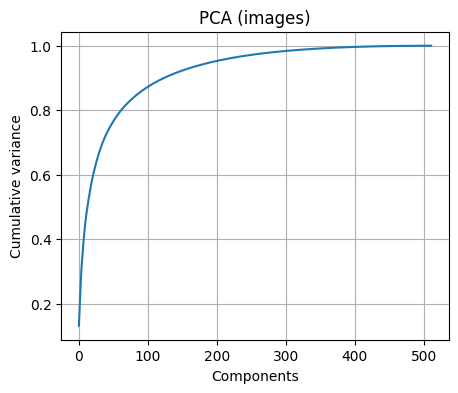

[PCA] components=549 | dim@90%=22 | dim@95%=27


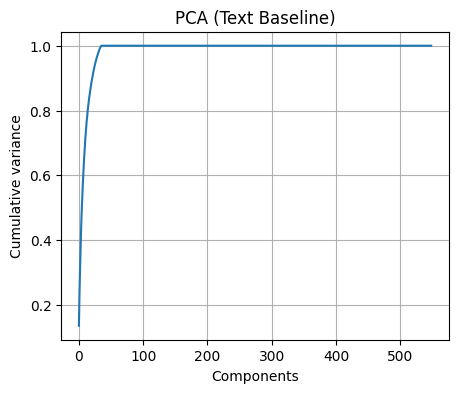

In [25]:
#@title 📈 Plots (PCA)

VERBOSE = True  # toggle debug prints

# Text: use the **class prototype** space (mean prompts per class), for task consistency
T_base = W_base.T.cpu().numpy()  # shape: [num_classes, dim]
T_eng  = W_eng.T.cpu().numpy()
T_ens  = W_ens.T.cpu().numpy()
T_super = W_super.T.cpu().numpy()

I = all_image_feats  # already unit-norm, shape: [num_images, dim]

# PCA (images at 90/95%;
dims_img, p_img                 = pca_dims(I, thresholds=(0.90, 0.95))
dims_txt_base, p_txt_base       = pca_dims(T_base, thresholds=(0.90, 0.95))
dims_txt_eng,  p_txt_eng        = pca_dims(T_eng, thresholds=(0.90, 0.95))
dims_txt_ens,  p_txt_ens        = pca_dims(T_ens, thresholds=(0.90, 0.95))
dims_txt_super, p_txt_super     = pca_dims(T_super, thresholds=(0.90, 0.95))


# --- PCA (images) ---
cum_var_img = np.cumsum(p_img.explained_variance_ratio_)  # 1D array
if VERBOSE:
    k90 = int(np.searchsorted(cum_var_img, 0.90) + 1)
    k95 = int(np.searchsorted(cum_var_img, 0.95) + 1)
    print(f"[PCA] components={len(cum_var_img)} | dim@90%={k90} | dim@95%={k95}")

plt.figure(figsize=(5, 4))
plt.plot(cum_var_img)
plt.xlabel("Components")
plt.ylabel("Cumulative variance")
plt.title("PCA (images)")
plt.grid(True)
plt.show()

# --- PCA (Text) ---


cum_var = np.cumsum(p_txt_base.explained_variance_ratio_)  # 1D array
# adapt to have a plot comparable with the img one
size_step_img = len(cum_var_img)
cum_var = np.concatenate([cum_var, np.ones(size_step_img)])

if VERBOSE:
    k90 = int(np.searchsorted(cum_var, 0.90) + 1)
    k95 = int(np.searchsorted(cum_var, 0.95) + 1)
    print(f"[PCA] components={len(cum_var)} | dim@90%={k90} | dim@95%={k95}")
plt.figure(figsize=(5, 4))
plt.plot(cum_var)
plt.xlabel("Components")
plt.ylabel("Cumulative variance")
plt.title("PCA (Text Baseline)")
plt.grid(True)
plt.show()

# cum_var = np.cumsum(p_txt_eng.explained_variance_ratio_)  # 1D array
# size_step_img = len(cum_var_img)
# cum_var = np.concatenate([cum_var, np.ones(size_step_img)])

# if VERBOSE:
#     k90 = int(np.searchsorted(cum_var, 0.90) + 1)
#     k95 = int(np.searchsorted(cum_var, 0.95) + 1)
#     print(f"[PCA] components={len(cum_var)} | dim@90%={k90} | dim@95%={k95}")

# plt.figure(figsize=(5, 4))
# plt.plot(cum_var)
# plt.xlabel("Components")
# plt.ylabel("Cumulative variance")
# plt.title("PCA (Text Engineered.)")
# plt.grid(True)
# plt.show()


# cum_var = np.cumsum(p_txt_ens.explained_variance_ratio_)  # 1D array
# size_step_img = len(cum_var_img)
# cum_var = np.concatenate([cum_var, np.ones(size_step_img)])

# if VERBOSE:
#     k90 = int(np.searchsorted(cum_var, 0.90) + 1)
#     k95 = int(np.searchsorted(cum_var, 0.95) + 1)
#     print(f"[PCA] components={len(cum_var)} | dim@90%={k90} | dim@95%={k95}")

# plt.figure(figsize=(5, 4))
# plt.plot(cum_var)
# plt.xlabel("Components")
# plt.ylabel("Cumulative variance")
# plt.title("PCA (Text Ensemble)")
# plt.grid(True)
# plt.show()

# cum_var = np.cumsum(p_txt_super.explained_variance_ratio_)  # 1D array
# size_step_img = len(cum_var_img)
# cum_var = np.concatenate([cum_var, np.ones(size_step_img)])

# if VERBOSE:
#     k90 = int(np.searchsorted(cum_var, 0.90) + 1)
#     k95 = int(np.searchsorted(cum_var, 0.95) + 1)
#     print(f"[PCA] components={len(cum_var)} | dim@90%={k90} | dim@95%={k95}")

# plt.figure(figsize=(5, 4))
# plt.plot(cum_var)
# plt.xlabel("Components")
# plt.ylabel("Cumulative variance")
# plt.title("PCA (Text Super (Ensemble + orthogonal))")
# plt.grid(True)
# plt.show()




In [26]:
#@title 📊 PCA dims @90/95% variance (images vs. texts)

VERBOSE = True  # toggle debug prints

if VERBOSE:
    print(f"[Shapes] Images: I={I.shape}")
    print(f"[Shapes] Text (baseline):  T_base={T_base.shape}")
    print(f"[Shapes] Text (engineered):T_eng ={T_eng.shape}")
    print(f"[Shapes] Text (ensemble):  T_ens ={T_ens.shape}")
    print(f"[Shapes] Text (super):  T_ens ={T_super.shape}")

print("PCA dims @90/95% variance:")
print("Images:           ", dims_img,
      "    |\nText baseline:   ", dims_txt_base,
      "|\nText engineered: ", dims_txt_eng,
      "|\nText ensemble:   ", dims_txt_ens,
      "|\nText super:   ", dims_txt_super)


[Shapes] Images: I=(1600, 512)
[Shapes] Text (baseline):  T_base=(37, 512)
[Shapes] Text (engineered):T_eng =(37, 512)
[Shapes] Text (ensemble):  T_ens =(37, 512)
[Shapes] Text (super):  T_ens =(37, 512)
PCA dims @90/95% variance:
Images:            {'dim_90': 125, 'dim_95': 196}     |
Text baseline:    {'dim_90': 22, 'dim_95': 27} |
Text engineered:  {'dim_90': 21, 'dim_95': 26} |
Text ensemble:    {'dim_90': 20, 'dim_95': 25} |
Text super:    {'dim_90': 20, 'dim_95': 26}


In [50]:
#@title 🔗 Build S and compute SVD

VERBOSE = False  # toggle debug prints

def effective_rank(S: np.ndarray, name: str = " ", verbose: bool=VERBOSE):
  U, s, VT = np.linalg.svd(S, full_matrices=False)
  energy = (s**2) / (s**2).sum()
  cum = np.cumsum(energy)
  k90 = int(np.searchsorted(cum, 0.90) + 1)
  k95 = int(np.searchsorted(cum, 0.95) + 1)
  effective_rank= float(np.exp(-np.sum(energy * np.log(energy + 1e-12))))

  if VERBOSE:
      print(f"[SVD] S shape={S.shape} | singulars={len(s)} | "
            f"k@90%={k90} | k@95%={k95} | eff-rank≈{effective_rank:.2f}")

  print(f"SVD(S) {name}: k90={k90}, k95={k95}, effective-rank≈{effective_rank:.2f}")
  return k90, k95, effective_rank, U, s, VT



SVD(S) base: k90=1, k95=1, effective-rank≈1.28
SVD(S) eng: k90=1, k95=1, effective-rank≈1.29
SVD(S) ens: k90=1, k95=1, effective-rank≈1.28
SVD(S) super: k90=1, k95=1, effective-rank≈1.29


[SVD] S shape=(1600, 37) | singulars=37 | k@90%=1 | k@95%=1 | eff-rank≈1.28
SVD(S) base: k90=1, k95=1, effective-rank≈1.28
[SVD] S shape=(1600, 37) | singulars=37 | k@90%=1 | k@95%=1 | eff-rank≈1.29
SVD(S) eng: k90=1, k95=1, effective-rank≈1.29
[SVD] S shape=(1600, 37) | singulars=37 | k@90%=1 | k@95%=1 | eff-rank≈1.28
SVD(S) ens: k90=1, k95=1, effective-rank≈1.28
[SVD] S shape=(1600, 37) | singulars=37 | k@90%=1 | k@95%=1 | eff-rank≈1.29
SVD(S) super: k90=1, k95=1, effective-rank≈1.29
[SVD] S_super shape=(1600, 37)
[SVD] #singular values=37 | k@90%=1 | k@95%=1 | eff-rank≈1.29

Singular values: 37  |  k90=1, k95=1, effective-rank≈1.29

[Plot] Showing first K=30 singular values


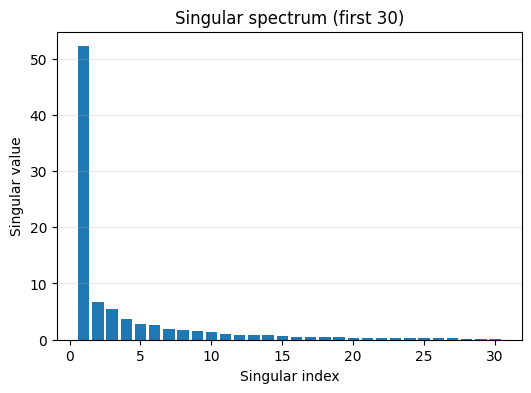

In [55]:
#@title 🔁 S, SVD, and spectrum (bars + cumulative)

VERBOSE = True  # toggle debug prints for this cell


S_base = all_image_feats @ (W_base).numpy()
_, _, _, U, s, VT = effective_rank(S=S_base, name = "base")

S_eng = all_image_feats @ (W_eng).numpy()
_, _, _, U, s, VT = effective_rank(S=S_eng, name = "eng")

S_ens = all_image_feats @ (W_ens).numpy()
_, _, _, U, s, VT = effective_rank(S=S_ens, name = "ens")

S_super = all_image_feats @ (W_super).numpy()
k90, k95, erank, U_svd, s_svd, VT_svd =  effective_rank(S=S_super, name = "super")


# Energy of singular values and cumulative energy
energy = (s_svd**2) / (s_svd**2).sum()
cum = np.cumsum(energy)


if VERBOSE:
    print(f"[SVD] S_super shape={S_super.shape}")
    print(f"[SVD] #singular values={len(s_svd)} | k@90%={k90} | k@95%={k95} | eff-rank≈{erank:.2f}\n")

print(f"Singular values: {len(s_svd)}  |  k90={k90}, k95={k95}, effective-rank≈{erank:.2f}\n")

# Plot: first KSHOW singular values + cumulative energy
KSHOW = min(30, len(s_svd))
if VERBOSE:
    print(f"[Plot] Showing first K={KSHOW} singular values")

plt.figure(figsize=(6, 4))
plt.bar(np.arange(1, KSHOW + 1), s_svd[:KSHOW])
plt.xlabel("Singular index")
plt.ylabel("Singular value")
plt.title("Singular spectrum (first 30)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()



[Heatmap] S shape=(1600, 37) | vmin≈0.109 vmax≈0.343 | ks=(1, 5, 10)
[Recon] SVD shapes: U=(1600, 37), s=(37,), VT=(37, 37) | target rank k=1 (S≈1600×37)
[Recon] S_k shape=(1600, 37)
[Recon] SVD shapes: U=(1600, 37), s=(37,), VT=(37, 37) | target rank k=5 (S≈1600×37)
[Recon] S_k shape=(1600, 37)
[Recon] SVD shapes: U=(1600, 37), s=(37,), VT=(37, 37) | target rank k=10 (S≈1600×37)
[Recon] S_k shape=(1600, 37)


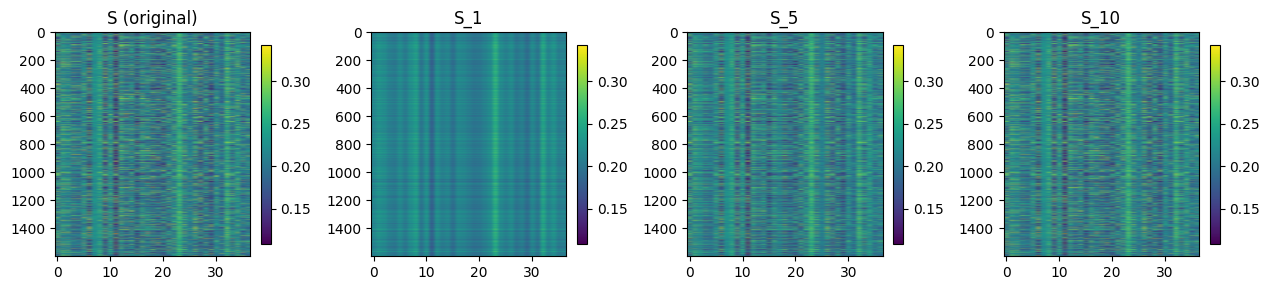

In [56]:
#@title 🔎 Rank-k reconstructions of S + heatmaps (simple & didactic)

VERBOSE = True  # toggle debug prints for this cell

def reconstruct_rank_k(U, s, VT, k, verbose: bool = VERBOSE):
    """
    Reconstruct a rank-k approximation of S from its SVD: S ≈ U_k Σ_k V_k^T
    Args:
        U, s, VT: SVD of S where S = U @ diag(s) @ VT
        k:        rank to keep (k <= min(S.shape))
    Returns:
        S_k: rank-k approximation of S
    """
    if verbose:
        m, n = U.shape[0], VT.shape[1]
        print(f"[Recon] SVD shapes: U={U.shape}, s={s.shape}, VT={VT.shape} | target rank k={k} (S≈{m}×{n})")

    Uk  = U[:, :k]        # [N, k]
    sk  = s[:k]           # [k]
    VTk = VT[:k, :]       # [k, M]
    Sk  = Uk @ (np.diag(sk) @ VTk)  # [N, M]

    if verbose:
        print(f"[Recon] S_k shape={Sk.shape}")
    return Sk


def show_heatmaps(S, U, s, VT, ks=(1, 5, 10), vmax=None, verbose: bool = VERBOSE):
    """
    Show the original S and a few rank-k reconstructions as heatmaps.
    Uses percentile clipping to avoid outliers dominating the colormap.
    """
    if vmax is None:
        vmax = np.percentile(S, 99)   # reduce outlier influence
    vmin = np.percentile(S, 1)

    if verbose:
        print(f"[Heatmap] S shape={S.shape} | vmin≈{vmin:.3f} vmax≈{vmax:.3f} | ks={ks}")

    ncol = len(ks) + 1
    plt.figure(figsize=(3.2 * ncol, 3))

    # Original S
    plt.subplot(1, ncol, 1)
    plt.imshow(S, aspect="auto", vmin=vmin, vmax=vmax)
    plt.title("S (original)")
    plt.colorbar(fraction=0.046)

    # Rank-k reconstructions
    for j, k in enumerate(ks, start=2):
        Sk = reconstruct_rank_k(U, s, VT, k, verbose=verbose)
        plt.subplot(1, ncol, j)
        plt.imshow(Sk, aspect="auto", vmin=vmin, vmax=vmax)
        plt.title(f"S_{k}")
        plt.colorbar(fraction=0.046)

    plt.tight_layout()
    plt.show()


# Example usage (assumes S_super, U_svd, s_svd, VT_svd are defined from the previous cell)
show_heatmaps(S_super, U_svd, s_svd, VT_svd, ks=(1, 5, 10), vmax=None, verbose=VERBOSE)


[SVD] S shape=(1600, 37) | singulars=37 | k@90%=1 | k@95%=1 | eff-rank≈1.29
SVD(S) super: k90=1, k95=1, effective-rank≈1.29
[Prompts] total prompts=444 (should match S_super.shape[1]=37)
[Recon] SVD shapes: U=(1600, 37), s=(37,), VT=(37, 37) | target rank k=1 (S≈1600×37)
[Recon] S_k shape=(1600, 37)
[Recon] SVD shapes: U=(1600, 37), s=(37,), VT=(37, 37) | target rank k=5 (S≈1600×37)
[Recon] S_k shape=(1600, 37)

=== Image idx 683 ===
[Image] S row shape=(37,) | S1 row shape=(37,) | S5 row shape=(37,)
[Debug] image_tensor shape: (3, 224, 224) (C,H,W)
[Debug] after denorm (CHW): shape=(3, 224, 224), dtype=torch.float32, device=cpu
[Debug] value range (pre-clamp): [0.000, 0.988]


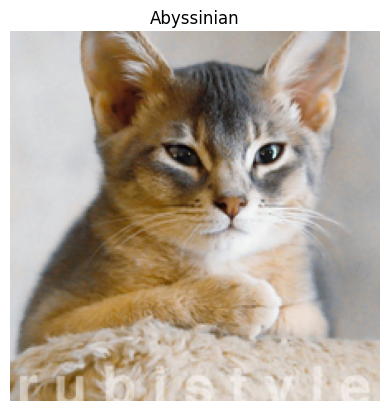

[TopPrompts] image=683 | matrix row shape=(37,) | topk=8

S (full)  | Top-8 prompts:
    0.302  ::  an image of a Abyssinian.
    0.284  ::  a picture of a Abyssinian cat.
    0.275  ::  a portrait of a Abyssinian breed.
    0.273  ::  a photo of a American Pit Bull Terrier dog.
    0.270  ::  a portrait of a American Pit Bull Terrier breed.
    0.269  ::  a photo of a American Bulldog dog.
    0.259  ::  a close-up photo of a Abyssinian.
    0.257  ::  a picture of a American Bulldog cat.
[TopPrompts] image=683 | matrix row shape=(37,) | topk=8

S_1 (rank-1)  | Top-8 prompts:
    0.252  ::  a picture of a American Bulldog cat.
    0.238  ::  a photo of a Abyssinian dog.
    0.238  ::  a photo of a American Pit Bull Terrier dog.
    0.229  ::  a cat of breed Abyssinian.
    0.227  ::  a photo of a Abyssinian.
    0.226  ::  a cat of breed American Pit Bull Terrier.
    0.224  ::  an image of a American Bulldog.
    0.222  ::  a bright photo of a Abyssinian.
[TopPrompts] image=683 | mat

In [65]:
#@title 🧩 Top prompts for one image: S vs S1 vs S5 (simple & didactic)

VERBOSE = True  # toggle debug prints for this cell

def top_prompts_for_image(i, S, prompt_strings, topk=8, verbose: bool = VERBOSE):
    """
    Return top-k prompts (indices, scores, texts) for image i given a score matrix S.
    S is [N_images, N_prompts]; prompt_strings is a list of length N_prompts.
    """
    row = S[i]  # shape: [N_prompts]
    idx = np.argsort(-row)[:topk]
    out = [(int(j), float(row[j]), prompt_strings[j]) for j in idx]
    if verbose:
        print(f"[TopPrompts] image={i} | matrix row shape={row.shape} | topk={topk}")
    return out








k90, k95, erank, U_svd, s_svd, VT_svd =  effective_rank(S=S_eng, name = "super")
# Rebuild the exact list of prompt strings used in T_all_super
# Order: for each label in 'classes', all templates in 'templates_super_ensemble'
T_strings = []
for lbl in classes:
    name = clean_label(lbl)
    T_strings += [t.format(name) for t in templates_ensemble]
if VERBOSE:
    print(f"[Prompts] total prompts={len(T_strings)} (should match S_super.shape[1]={S_super.shape[1]})")

# Rank-1 and Rank-5 reconstructions of S (use SVD from previous cell)
S1 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 1, verbose=VERBOSE)
S5 = reconstruct_rank_k(U_svd, s_svd, VT_svd, 5, verbose=VERBOSE)

# Show a few random images and their top prompts across S, S1, S5
n_imgs_to_show = 1
for i in random.sample(range(S_super.shape[0]), n_imgs_to_show):
    print(f"\n=== Image idx {i} ===")
    if VERBOSE:
        print(f"[Image] S row shape={S_super[i].shape} | S1 row shape={S1[i].shape} | S5 row shape={S5[i].shape}")

    # Display the image and its class label (assumes ds_sub is aligned with S rows)
    specific_image, specific_label = ds_sub[i]
    display_image_from_tensor(specific_image, classes[specific_label])

    # Compare top prompts from full S and low-rank approximations
    for tag, M in [("S (full)", S_super), ("S_1 (rank-1)", S1), ("S_5 (rank-5)", S5)]:
        tops = top_prompts_for_image(i, M, T_strings, topk=8, verbose=VERBOSE)
        print(f"\n{tag}  | Top-8 prompts:")
        for j, score, txt in tops:
            print(f"  {score:7.3f}  ::  {txt}")


Take-home message 🏡

- **Visual space is bigger.**
Images need many more PCA components to explain their variation than text prompts do. (Think: breed, pose, lighting, background… all add dimensions.)

- **One axis rules them all.**
SVD of the image–text similarity matrix is very low-rank (often ≈1). Most of the coupling rides on a single direction, while finer factors (breed, pose, style) barely register.

What to do next

- **Richer prompts, more axes:** vary scene, viewpoint, action, lighting, background, count; compose multiple attributes in one prompt.

- **Use longer, descriptive text:** not just class names—add details that map to visual factors.

- **(Advanced)** Learn better text direction, (prompt tuning/textual inversion) or add model capacity (multi-head/cross-attention) to capture more than one shared axis.